In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf

In [2]:
#importing the dataset
df = pd.read_csv('Tweets.csv')

In [3]:
#printing first 5 rows
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
#checking the dypes of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# PART 1 : EDA AND FEATURE ENGINEERING
A. EDA

In [5]:
#Dataset dimensions (rows, columns)
print("dataset shape:", df.shape)

dataset shape: (14640, 15)


In [6]:
#Checking nulls
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

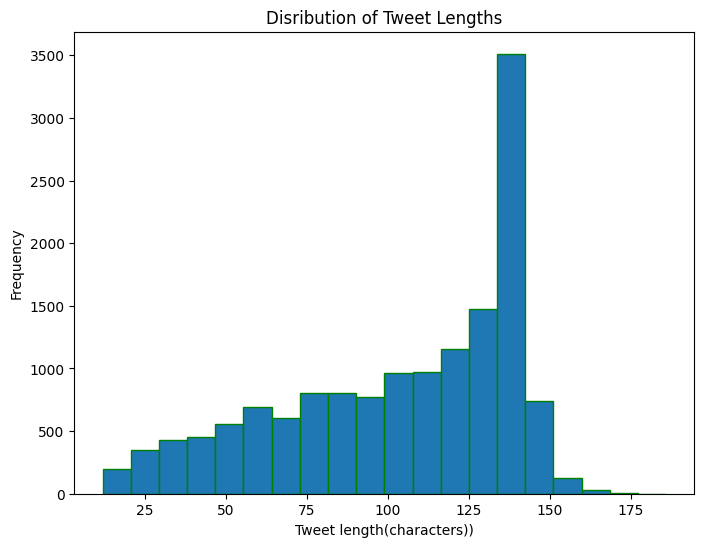

In [7]:
#Explore the tweet length distributions
df['tweet_length'] = df['text'].apply(len)

#plot the tweet length distribution
plt.figure(figsize=(8,6))
plt.hist(df['tweet_length'], bins = 20, edgecolor = 'green')
plt.title("Disribution of Tweet Lengths")
plt.xlabel("Tweet length(characters))")
plt.ylabel("Frequency")
plt.show()

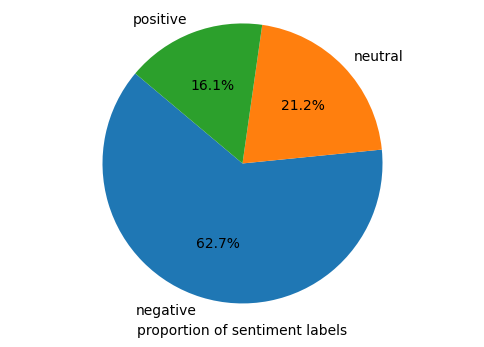

In [8]:
#count sentiment labels
label_count = df['airline_sentiment'].value_counts()

#graph for label distribution
plt.figure(figsize  = (6,4))
plt.pie(label_count, labels = label_count.index, autopct='%1.1f%%', startangle=140)
plt.xlabel("proportion of sentiment labels")
plt.axis('equal')
plt.show()

PART B - TEXT VISUALIZATION

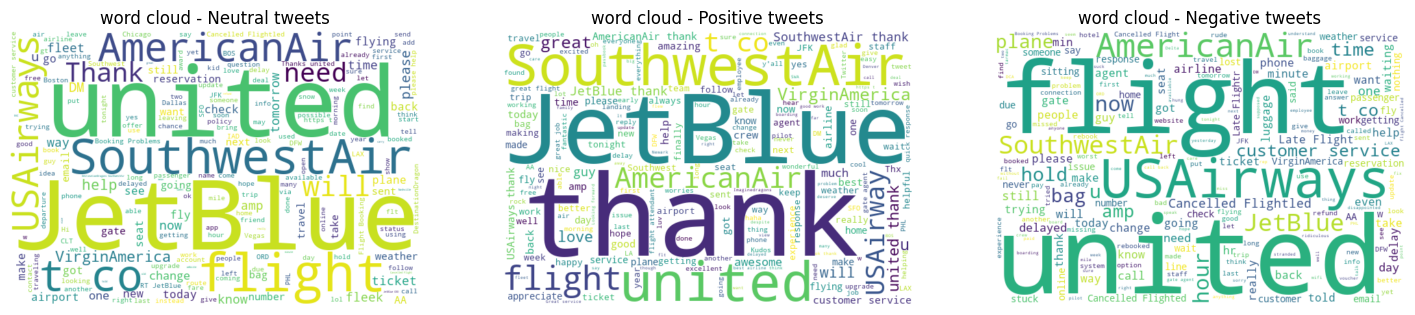

In [9]:
#Word clouds per class importing wordcloud
from wordcloud import WordCloud

#create wordclouds per each sentiment
sentiments = df['airline_sentiment'].unique()
#plotting the wordclouds
plt.figure(figsize  = (18,8))
for i, sentiment in enumerate(sentiments):
    text_data = "".join(df[df['airline_sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='viridis').generate(text_data)
    plt.subplot(1, 3, i + 1)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title(f"word cloud - {sentiment.title()} tweets")
plt.show()

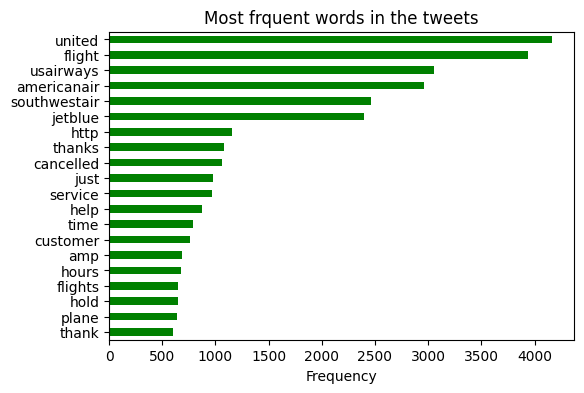

In [10]:
#top N frequrnt word recurrence
from sklearn.feature_extraction.text import CountVectorizer
#set the top frequent words as 20
count = 20

#vectorize text data to count the freq
vectorizer = CountVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(df['text'])
word_freq_count = pd.Series(X.sum(axis=0).A1, index=vectorizer.get_feature_names_out()).sort_values(ascending=False).head(count)

plt.figure(figsize  = (6,4))
word_freq_count[::-1].plot(kind = 'barh', color = 'green')
plt.title("Most frquent words in the tweets")
plt.xlabel("Frequency")
plt.show()


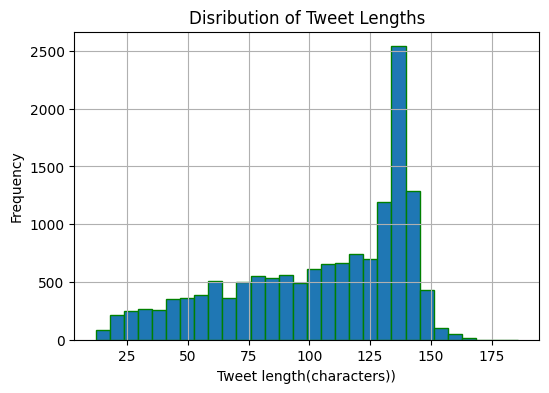

In [11]:
#Explore the tweet length distributions
df['tweet_length'] = df['text'].apply(len)

#plot the tweet length distribution
plt.figure(figsize=(6,4))
plt.hist(df['tweet_length'], bins = 30, edgecolor = 'green')
plt.title("Disribution of Tweet Lengths")
plt.xlabel("Tweet length(characters))")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

PREPROCESS AND FEATURE ENGINEERING

In [12]:
#mport all the required libraries for preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

#intializing the tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

#cleaning the text column

def cleaning(text):
    #convert text to lower case
    text = text.lower()
    #remove non alphabetic char and punctuatoions
    text = re.sub(r'[^a-z\s]', ' ', text)
    #tokenize and remove the stopwords from the text
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

#apply cleaning to the text column
df['cleaned_text'] = df['text'].apply(cleaning)
df[['text', 'cleaned_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,cleaned_text
0,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,virginamerica plu ad commerci experi tacki
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica today must mean need take anoth ...
3,@VirginAmerica it's really aggressive to blast...,virginamerica realli aggress blast obnoxi ente...
4,@VirginAmerica and it's a really big bad thing...,virginamerica realli big bad thing


In [13]:
#bag of words representation

vectorizer_bow = CountVectorizer()
X = vectorizer_bow.fit_transform(df['cleaned_text'])

print("bow shape:", X.shape)


bow shape: (14640, 10805)


In [14]:
#TF-IDF represntation

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
X = vectorizer_tfidf.fit_transform(df['cleaned_text'])

print("tfidf shape:", X.shape)

tfidf shape: (14640, 10805)


# PART 2 - MODEL BUILDING


Classification Report Logstic regression:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87      1835
           1       0.65      0.52      0.58       620
           2       0.79      0.58      0.66       473

    accuracy                           0.79      2928
   macro avg       0.75      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928


Confusion matrix logistic regression:
 [[1707   89   39]
 [ 260  325   35]
 [ 117   84  272]]


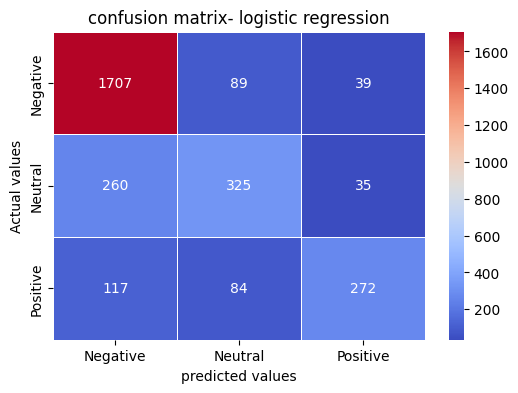


Classification Report D tree:
               precision    recall  f1-score   support

           0       0.72      0.92      0.81      1835
           1       0.47      0.20      0.28       620
           2       0.70      0.50      0.58       473

    accuracy                           0.70      2928
   macro avg       0.63      0.54      0.56      2928
weighted avg       0.67      0.70      0.66      2928


Confusion matrix Dtree:
 [[1682   82   71]
 [ 463  124   33]
 [ 179   57  237]]


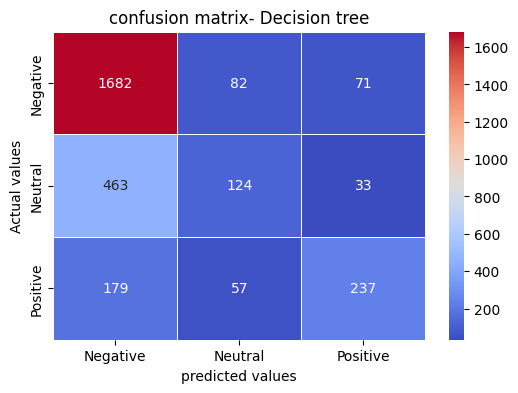

In [15]:
#Two simple models (logistic regression and decision tree)
#importing required librabries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#Encode labels from string to integer 
label_encoder = LabelEncoder()
df['airline_sentiment1'] = label_encoder.fit_transform(df['airline_sentiment'])

#using the cleaned text column as a feature
X = df['cleaned_text']
#airline sentiment as a target variable
Y = df['airline_sentiment1']

#split the dtaset into train and test as 80%-train and 20% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify = df['airline_sentiment1'], random_state = 42)

#vectorize text using TF-IDF
#limit the max_features to 5000 keeping it simple for training time
tf_idf = TfidfVectorizer(max_features = 5000)
X_train_tfidf =  tf_idf.fit_transform(X_train)
X_test_tfidf =  tf_idf.transform(X_test)

#model1  - logistic regression
#not applying any regularisation L2 reg and c=1.0 will be applied by default
#keeping max_iter simple as 1000
model1_logreg = LogisticRegression(max_iter = 1000, random_state = 42)

#train the logistic reg
model1_logreg.fit(X_train_tfidf, Y_train)

#make prediction on the testing data
model1_logreg_pred = model1_logreg.predict(X_test_tfidf)


print("\nClassification Report Logstic regression:\n", classification_report(Y_test, model1_logreg_pred, zero_division=0))
print("\nConfusion matrix logistic regression:\n", confusion_matrix(Y_test, model1_logreg_pred))

labels = ['Negative', 'Neutral', 'Positive']
cm1 = confusion_matrix(Y_test, model1_logreg_pred)
#visualize confusion matrix
plt.figure(figsize = (6, 4))
#generate heatmap
sns.heatmap(cm1, annot = True, cmap = 'coolwarm', fmt = "d", linewidth = 0.5, xticklabels=labels, yticklabels=labels)
#add title 
plt.title("confusion matrix- logistic regression", fontsize = 12)
plt.xlabel("predicted values")
plt.ylabel("Actual values")
plt.show()

#model2 - desicion tree
#using max_depth as 10 to reduce complexity and training process
model2_dtree = DecisionTreeClassifier(max_depth = 10, random_state = 42)

#train the decison tree model
model2_dtree.fit(X_train_tfidf, Y_train)

#make prediction on the testing data
model2_dtree_pred = model2_dtree.predict(X_test_tfidf)


print("\nClassification Report D tree:\n", classification_report(Y_test, model2_dtree_pred, zero_division=0))
print("\nConfusion matrix Dtree:\n", confusion_matrix(Y_test, model2_dtree_pred))

cm2 = confusion_matrix(Y_test, model2_dtree_pred)
#visualize confusion matrix
plt.figure(figsize = (6, 4))
#generate heatmap
sns.heatmap(cm2, annot = True, cmap = 'coolwarm', fmt = "d", linewidth = 0.5, xticklabels=labels, yticklabels=labels)
#add title 
plt.title("confusion matrix- Decision tree", fontsize = 12)
plt.xlabel("predicted values")
plt.ylabel("Actual values")
plt.show()

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.6465 - loss: 0.8366 - val_accuracy: 0.7713 - val_loss: 0.5702
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.8177 - loss: 0.4735 - val_accuracy: 0.7995 - val_loss: 0.5234
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.8755 - loss: 0.3465 - val_accuracy: 0.7850 - val_loss: 0.5509
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.9089 - loss: 0.2554 - val_accuracy: 0.7705 - val_loss: 0.5976
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.9305 - loss: 0.2025 - val_accuracy: 0.7594 - val_loss: 0.7303
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.9429 - loss: 0.1614 - val_accuracy: 0.7688 - val_loss: 0.7417
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - accuracy: 0.9548 - loss: 0.1363 - val_accuracy: 0.7483 - val_loss: 0.9304
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.9589 - loss: 0.1191

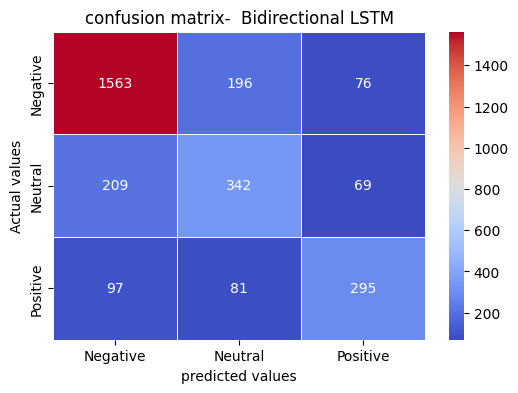

In [16]:
#model 3 LSTM- Black box
#importing the required libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

#we already splitted the data into train and test.

#using tokenizer to convert text to integer sequences
tokenizer = Tokenizer(num_words = 20000, oov_token =  "<OOV>")
tokenizer.fit_on_texts(X_train)

#convert the tokenized text to sequences
seq_X_train = tokenizer.texts_to_sequences(X_train)
seq_X_test = tokenizer.texts_to_sequences(X_test)

#pad thesequences to the same length
pad_X_train = pad_sequences(seq_X_train, maxlen = 50, padding = 'post')
pad_X_test = pad_sequences(seq_X_test, maxlen = 50, padding = 'post')

#LSTM model architecture
#applyin word embedding, LSTM layer, dropout ot reduce overfitting and output layer softmax.
model3 = Sequential()
model3.add(Embedding(input_dim = 20000, output_dim = 128))
model3.add(Bidirectional(LSTM(64)))
model3.add(Dropout(0.5))
model3.add(Dense(3, activation = 'softmax'))

#Compile the model using the adam optimizer
model3.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

"""training the LSTM model using input features and labels
epochs - keeping it simple 10 full passes
batch_size - training data split size
validation-split -10% trainig data used for validation to monitor overfitting
verbose - show progress and training details for each epochs
"""
model3.fit(pad_X_train, Y_train, epochs = 10, batch_size = 64, validation_split = 0.1, verbose = 1)

#predict the target probablities then take argmax
Y_pred_prob = model3.predict(pad_X_test)
Y_pred = np.argmax(Y_pred_prob, axis = 1)


#printing the evaluation metrics
print("\nClassification Report BIdirectional LSTM:\n", classification_report(Y_test, Y_pred, zero_division=0))
print("\nConfusion matrix BIdirectional LSTM:\n", confusion_matrix(Y_test, Y_pred))

cm3 = confusion_matrix(Y_test, Y_pred)
#visualize confusion matrix
plt.figure(figsize = (6, 4))
#generate heatmap
sns.heatmap(cm3, annot = True, cmap = 'coolwarm', fmt = "d", linewidth = 0.5, xticklabels=labels, yticklabels=labels)
#add title 
plt.title("confusion matrix-  Bidirectional LSTM", fontsize = 12)
plt.xlabel("predicted values")
plt.ylabel("Actual values")
plt.show()

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.6579 - loss: 0.8131 - val_accuracy: 0.7287 - val_loss: 0.6355
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.7884 - loss: 0.5486 - val_accuracy: 0.7611 - val_loss: 0.6126
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.8671 - loss: 0.3830 - val_accuracy: 0.7654 - val_loss: 0.6113
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9181 - loss: 0.2544 - val_accuracy: 0.7381 - val_loss: 0.7119
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9424 - loss: 0.1810 - val_accuracy: 0.7432 - val_loss: 0.7453
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9491 - loss: 0.1598 - val_accuracy: 0.7355 - val_loss: 0.8490
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.9675 - loss: 0.1083 - val_accuracy: 0.7312 - val_loss: 0.8542
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9674 - loss: 0.0996 - val_acc

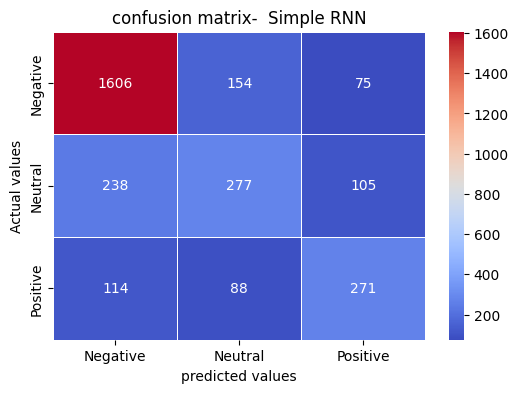

In [17]:
#model 4 - RNN blcak box
#importing the required librabries
from tensorflow.keras.layers import SimpleRNN

#we already splitted the data into train and test.

#using tokenizer to convert text to integer sequences
tokenizer = Tokenizer(num_words = 20000, oov_token =  "<OOV>")
tokenizer.fit_on_texts(X_train)

#convert the tokenized text to sequences
seq_X_train = tokenizer.texts_to_sequences(X_train)
seq_X_test = tokenizer.texts_to_sequences(X_test)

#pad thesequences to the same length
pad_X_train = pad_sequences(seq_X_train, maxlen = 50, padding = 'post')
pad_X_test = pad_sequences(seq_X_test, maxlen = 50, padding = 'post')

#RNN model architecture
#applyin word embedding, simple RNN layer, dropout  to reduce overfitting and output layer softmax.
model4 = Sequential()
model4.add(Embedding(input_dim = 20000, output_dim = 128))
model4.add(SimpleRNN(64))
model4.add(Dropout(0.5))
model4.add(Dense(3, activation = 'softmax'))

#Compile the model using the adam optimizer
model4.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

"""training the RNN model using input features and labels
epochs - keeping it simple 10 full passes
batch_size - training data split size
validation-split -10% trainig data used for validation to monitor overfitting
verbose - show progress and training details for each epochs
"""
model4.fit(pad_X_train, Y_train, epochs = 10, batch_size = 64, validation_split = 0.1, verbose = 1)

#predict the target probablities then take argmax
Y_pred_prob = model4.predict(pad_X_test)
Y_pred = np.argmax(Y_pred_prob, axis = 1)


#printing the evaluation metrics
print("\nClassification Report RNN:\n", classification_report(Y_test, Y_pred, zero_division=0))
print("\nConfusion matrix RNN:\n", confusion_matrix(Y_test, Y_pred))

cm4 = confusion_matrix(Y_test, Y_pred)
#visualize confusion matrix
plt.figure(figsize = (6, 4))
#generate heatmap
sns.heatmap(cm4, annot = True, cmap = 'coolwarm', fmt = "d", linewidth = 0.5, xticklabels=labels, yticklabels=labels)
#add title 
plt.title("confusion matrix-  Simple RNN", fontsize = 12)
plt.xlabel("predicted values")
plt.ylabel("Actual values")
plt.show()



# Interpretation, Error Analysis & Trade-Offs

In [18]:
# Display the list of the text true label and predicted label
text_data = X_test.tolist()
true_sentiment = Y_test.tolist()
predicted_sentiment = Y_pred.tolist()

# Create a DataFrame for easy viewing
import pandas as pd

df_output = pd.DataFrame({
    'Text data': text_data,
    'True sentment': true_sentiment,
    'Predicted sentiment': predicted_sentiment
})
pd.set_option('display.max_colwidth', None)


#prnt top 50 predictions
df_output.head(50)

,Text data,True sentment,Predicted sentiment
0,unit past,1,0
1,jetblu would say delay like thank much,2,1
2,jetblu cheat sorri never southwestair given wife worst start honeymoon ever,0,0
3,unit disappoint u didnt honor credit given ur mistak take busi elsewher,0,0
4,usairway airlin embarrass get bad weather fault respons wors,0,0
5,americanair flight delay amp talk reach anyon custom servic high call volum,0,0
6,unit link tweet goe someon intern email gt http co zksx itdn probabl one rd parti contract,1,0
7,southwestair betsi besti gettin stuck la might bad want home homewardbound betsi besti thankyou,0,0
8,usairway mani agent work handl thousand call,0,0
9,southwestair flight resum see open schedul,0,1
